# Long Term Open Source Metric Analysis

# Eclipse Swt Module Analysis

In [22]:
swt_versions = ["2.1", "3.0", "3.1","3.2", "3.3", "3.4","3.5", "3.6","3.7","3.8","4.2","4.3","4.4","4.5",
                  "4.6","4.7","4.8", "4.9"
            ]


neededColumnsClass =['cbo','cboModified','fanin','fanout','wmc','dit','noc','lcom',
                     'lcom*','tcc','lcc', 'loc'
               ]
kafka_versions = ["3.4.1","3.4.0","3.3.2","3.3.1",
                "3.2.3","3.2.1","3.2.0","3.1.2","3.1.1","3.1.0","3.0.2","3.0.1","3.0.0",
                "2.8.2","2.8.1","2.8.0","2.7.2","2.7.1","2.7.0","2.6.3","2.6.2","2.6.1",
                "2.6.0","2.5.1","2.5.0","2.4.1","2.4.0","2.3.1","2.3.0",
                "2.2.2","2.2.1","2.2.0","2.1.1","2.1.0","2.0.1","2.0.0","1.1.1","1.1.0",
                "1.0.2","1.0.1","1.0.0","0.11.0.3","0.11.0.2","0.11.0.1","0.11.0.0",
                "0.10.2.2","0.10.2.1","0.10.2.0","0.10.1.1","0.10.1.0","0.10.0.0",
                "0.9.0.1","0.9.0.0","0.8.2.2","0.8.2.1","0.8.2.0","0.8.1.9",
                "0.8.1.1","0.8.1","0.8.0","0.7.9"
            ]

In [23]:
import pandas as pd

classCkMetricsAllVersionsDfClass = pd.read_csv('DataSource/swt_AllCkMetricsAllVersionsClass.csv')

In [24]:
swt_bugsDf = pd.read_csv('DataSource/swt_bugs_all.csv')

In [25]:
cleanedCkMetricsAllVersionsDf = (classCkMetricsAllVersionsDfClass
    .loc[~classCkMetricsAllVersionsDfClass['class'].str.contains("Test")]
    .loc[~classCkMetricsAllVersionsDfClass['class'].str.contains("test")]
    .loc[~classCkMetricsAllVersionsDfClass['class'].str.contains("TEST")]
    .loc[~classCkMetricsAllVersionsDfClass['file'].str.contains("src/test/")]
) 

In [26]:
print("Filtrelenmiş sınıf sayısı:", cleanedCkMetricsAllVersionsDf.shape[0])
print("Versionlanmış hata sayısı:", swt_bugsDf['Summary'].count())


Filtrelenmiş sınıf sayısı: 16266
Versionlanmış hata sayısı: 8444


In [27]:
meanCkGroupedVersions = cleanedCkMetricsAllVersionsDf.groupby("Version", as_index=False)[neededColumnsClass].mean()
stdCkGroupedVersions = cleanedCkMetricsAllVersionsDf.groupby("Version", as_index=False)[neededColumnsClass].std()
maxCkGroupedVersions = cleanedCkMetricsAllVersionsDf.groupby("Version", as_index=False)[neededColumnsClass].max()
locVersions = cleanedCkMetricsAllVersionsDf.groupby("Version", as_index=False)['loc'].sum()
bugsGroupedDf = swt_bugsDf.groupby(['Version']).count().reset_index()

locVersions['Version'] = locVersions['Version'].astype(str)
swt_bugsDf['Version'] = swt_bugsDf['Version'].astype(str)
locVersions = pd.merge(locVersions, bugsGroupedDf,on="Version", how='inner')



In [28]:

swt_bugsGroupedDf= swt_bugsDf[swt_bugsDf['Version'].isin(swt_versions)].groupby("Version", as_index=False).count().rename(columns = {'Bug ID': 'Bug Count'})[['Version','Bug Count']]
swt_bugsGroupedDf['Version'] = swt_bugsGroupedDf['Version'].astype(float)



mergedMeanCountsDf = pd.merge(meanCkGroupedVersions, swt_bugsGroupedDf, on="Version", how='inner')
mergedStdCountsDf = pd.merge(stdCkGroupedVersions, swt_bugsGroupedDf, on="Version", how='inner')
mergedMaxCountsDf = pd.merge(maxCkGroupedVersions, swt_bugsGroupedDf, on="Version", how='inner')


In [29]:
import statsmodels.api as sm
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import train_test_split
from sklearn.metrics import r2_score, mean_squared_error

df = pd.merge(cleanedCkMetricsAllVersionsDf, swt_bugsGroupedDf, on="Version", how='inner')
cleanedCkMetricsAllVersionsDf.info()
df.columns = df.columns.str.upper()
df = df[['CBO', 'CBOMODIFIED', 'FANIN', 'FANOUT', 'WMC', 'DIT', 'NOC', 
                            'LCOM','LCOM*', 'TCC', 'LCC', 'LOC', 'VERSION','BUG COUNT' ]].dropna()
rows, columns = df.shape
print(f"Satır sayısı: {rows}, Sütun sayısı: {columns}")

lr= LinearRegression()

X = df[['CBO', 'CBOMODIFIED', 'FANIN', 'FANOUT', 'WMC', 'DIT', 'NOC', 
                            'LCOM','LCOM*', 'TCC', 'LCC', 'LOC' ]]
y = df['BUG COUNT']

print(X.shape)
print(y.shape)

Y = y.values.reshape(-1, 1)

x_train, x_test, y_train, y_test = train_test_split(X,Y, test_size=0.30, random_state=100)
print("X_train boyutu", x_train.shape)
print("x_test boyutu", x_test.shape)
print("y_train boyutu", y_train.shape)
print("y_test boyutu", y_test.shape)

lr.fit(x_train, y_train)

katsayılar = pd.DataFrame(lr.coef_, columns = ['CBO', 'CBOMODIFIED', 'FANIN', 'FANOUT', 'WMC', 'DIT', 'NOC', 'LCOM',
       'LCOM*', 'TCC', 'LCC', 'LOC' ])

katsayılar

y_pred = lr.predict(x_test)



# Means Squared Error Hesaplama

r_2 = r2_score(y_test, y_pred)

print(r_2 *100)



import statsmodels.api as sm


X_train_ols = sm.add_constant(x_train)

sm_model = sm.OLS(y_train, X_train_ols)

sonuc = sm_model.fit()

print(sonuc.summary())

<class 'pandas.core.frame.DataFrame'>
Index: 16266 entries, 0 to 16358
Data columns (total 54 columns):
 #   Column                  Non-Null Count  Dtype  
---  ------                  --------------  -----  
 0   Unnamed: 0              16266 non-null  int64  
 1   Version                 16266 non-null  float64
 2   file                    16266 non-null  object 
 3   class                   16266 non-null  object 
 4   type                    16266 non-null  object 
 5   cbo                     16266 non-null  int64  
 6   cboModified             16266 non-null  int64  
 7   fanin                   16266 non-null  int64  
 8   fanout                  16266 non-null  int64  
 9   wmc                     16266 non-null  int64  
 10  dit                     16266 non-null  int64  
 11  noc                     16266 non-null  int64  
 12  rfc                     16266 non-null  int64  
 13  lcom                    16266 non-null  int64  
 14  lcom*                   12836 non-null  flo

In [41]:
import statsmodels.api as sm
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import train_test_split
from sklearn.metrics import r2_score, mean_squared_error

df = mergedMaxCountsDf
print(df.head())
df.columns = df.columns.str.upper()
df = df[['CBO', 'CBOMODIFIED', 'FANIN', 'FANOUT', 'WMC', 'DIT', 'NOC', 
                            'LCOM','LCOM*', 'TCC', 'LCC', 'LOC', 'VERSION','BUG COUNT' ]]
rows, columns = df.shape
print(f"Satır sayısı: {rows}, Sütun sayısı: {columns}")



X = df[['CBO', 'CBOMODIFIED', 'FANIN', 'FANOUT', 'WMC', 'DIT', 'NOC', 
                            'LCOM','LCOM*', 'TCC', 'LCC', 'LOC' ]]
y = df['BUG COUNT']

print(X.shape)
print(y.shape)

Y = y.values.reshape(-1, 1)

x_train, x_test, y_train, y_test = train_test_split(X,Y, test_size=0.20, random_state=100)
print("X_train boyutu", x_train.shape)
print("x_test boyutu", x_test.shape)
print("y_train boyutu", y_train.shape)
print("y_test boyutu", y_test.shape)


import statsmodels.api as sm


X_train_ols = sm.add_constant(x_train)

X_train_ols.info()
sm_model = sm.OLS(y_train, X_train_ols)

sonuc = sm_model.fit()

print(sonuc.summary())

   VERSION  CBO  CBOMODIFIED  FANIN  FANOUT   WMC  DIT  NOC    LCOM  LCOM*  \
0      2.1   76          168    107      76   944    7   21  176448    1.0   
1      3.0  107          205    111     107   960    7   47  226206    1.0   
2      3.1  121          230    115     121  1075    7   69  291213    1.0   
3      3.2  123          247    124     123  1661    7   90  323461    1.0   
4      3.3  139          398    258     140  1950    7  116  500701    1.0   

   TCC  LCC   LOC  BUG COUNT  
0  1.0  1.0  4508        559  
1  1.0  1.0  4311       1007  
2  1.0  1.0  4464        760  
3  1.0  1.0  4918        572  
4  1.0  1.0  5333        498  
Satır sayısı: 18, Sütun sayısı: 14
(18, 12)
(18,)
X_train boyutu (14, 12)
x_test boyutu (4, 12)
y_train boyutu (14, 1)
y_test boyutu (4, 1)
<class 'pandas.core.frame.DataFrame'>
Index: 14 entries, 1 to 8
Data columns (total 12 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   CBO          14 non

/Users/ayferuckan/anaconda3/lib/python3.11/site-packages/scipy/stats/_stats_py.py:1806: UserWarning: kurtosistest only valid for n>=20 ... continuing anyway, n=14
  warnings.warn("kurtosistest only valid for n>=20 ... continuing "


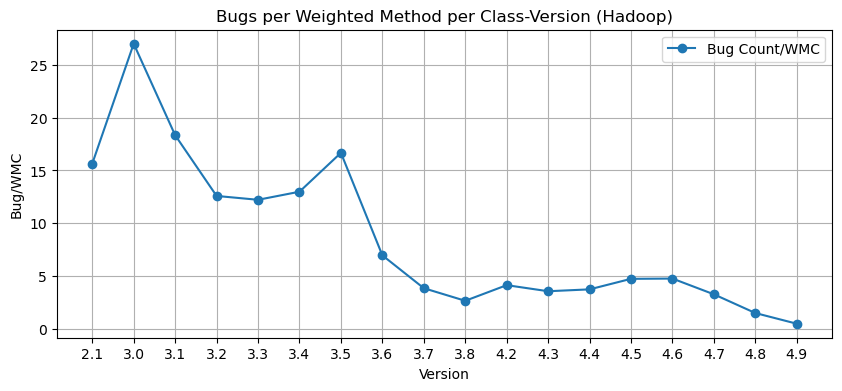

In [18]:
#Bugs per Weighted Method per Class
meanCkGroupedVersions['BugWeight'] = t_mergedMeanBugCountsDf['Bug Count']/mergedMeanCountsDf['wmc']

import matplotlib.pyplot as plt

plt.figure(figsize=(10, 4)) 
plt.plot(meanCkGroupedVersions['Version'], meanCkGroupedVersions['BugWeight'], marker='o', linestyle='-', label='Bug Count/WMC')


plt.ylabel('Bug/WMC')
plt.grid(True)

plt.xlabel('Version')
plt.title('Bugs per Weighted Method per Class-Version (Hadoop)')
plt.legend()  
plt.show()


In [10]:
t_mergedMeanBugCountsDf = mergedMeanCountsDf
t_mergedStdBugCountsDf = mergedStdCountsDf
t_mergedMaxBugCountsDf = mergedMaxCountsDf

t_mergedMeanBugCountsDf['BugDensity'] = t_mergedMeanBugCountsDf['Bug Count']/t_mergedMeanBugCountsDf['loc']


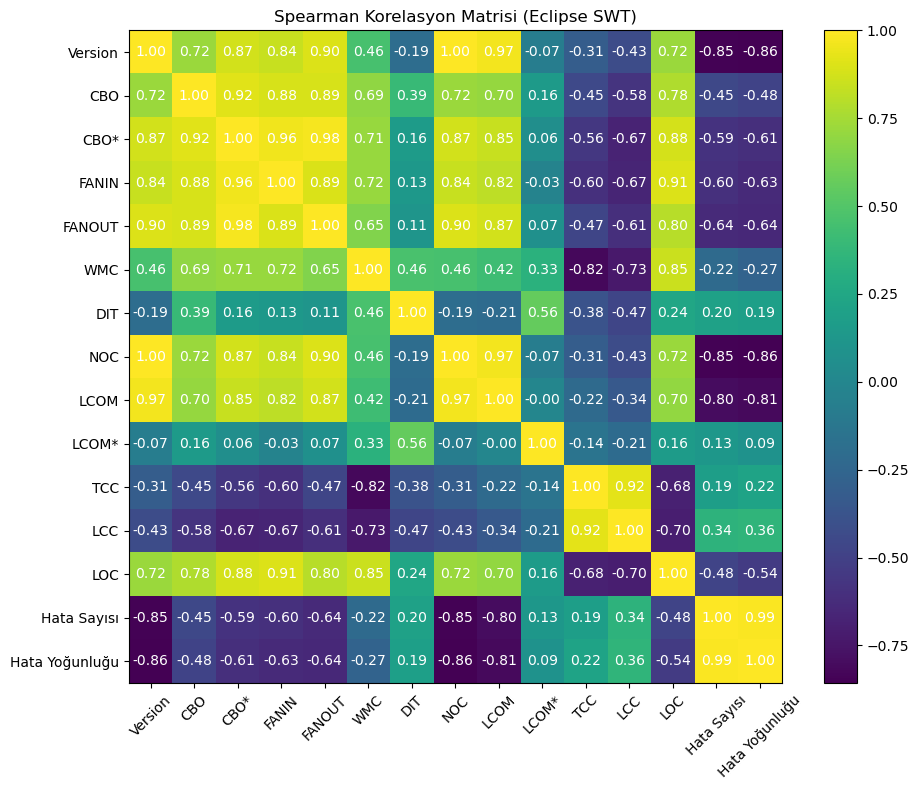

In [11]:
import numpy as np
import matplotlib.pyplot as plt

correlation_matrix = mergedMeanCountsDf.corr(method='spearman')

plt.figure(figsize=(10, 8))
plt.imshow(correlation_matrix, cmap='viridis', interpolation='nearest')

for i in range(len(correlation_matrix)):
    for j in range(len(correlation_matrix)):
        plt.text(j, i, f"{correlation_matrix.iloc[i, j]:.2f}", ha='center', va='center', color='white')

plt.colorbar()
plt.title('Spearman Korelasyon Matrisi (Eclipse SWT)')
correlation_matrix.columns = ['Version', 'CBO', 'CBO*', 'FANIN', 'FANOUT', 'WMC', 'DIT', 'NOC',
       'LCOM', 'LCOM*', 'TCC', 'LCC', 'LOC', 'Hata Sayısı', 'Hata Yoğunluğu']
correlation_matrix.index = ['Version', 'CBO', 'CBO*', 'FANIN', 'FANOUT', 'WMC', 'DIT', 'NOC',
       'LCOM', 'LCOM*', 'TCC', 'LCC', 'LOC', 'Hata Sayısı', 'Hata Yoğunluğu']
plt.xticks(np.arange(len(correlation_matrix)), correlation_matrix.columns, rotation=45)
plt.yticks(np.arange(len(correlation_matrix)), correlation_matrix.index)
plt.tight_layout()
plt.show()


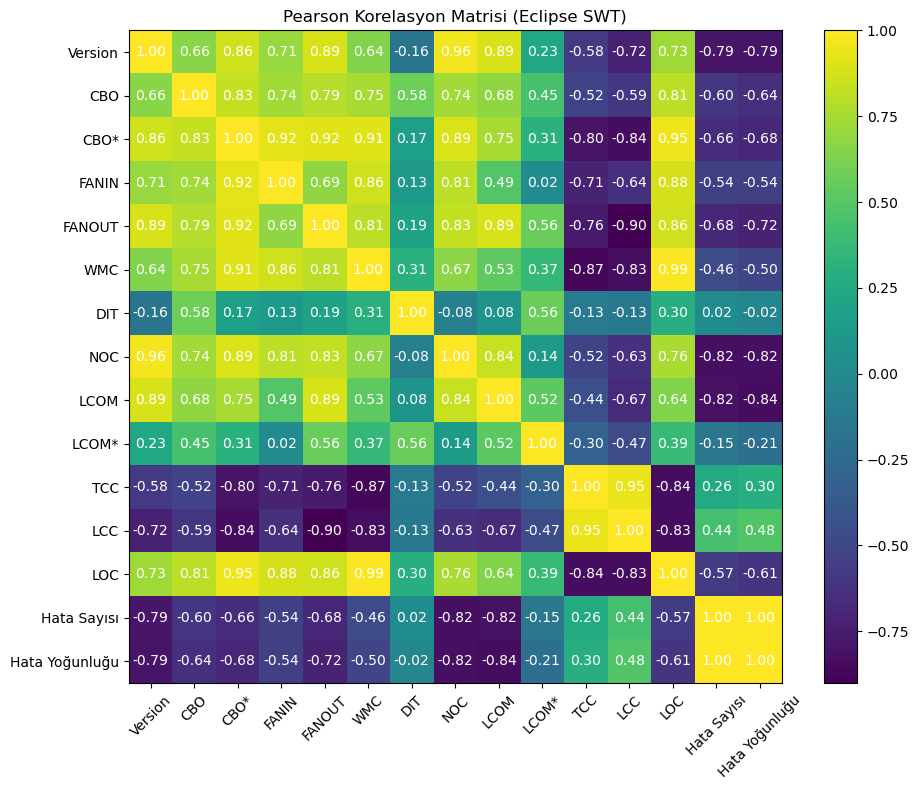

In [12]:
import numpy as np
import matplotlib.pyplot as plt

correlation_matrix = mergedMeanCountsDf.corr(method='pearson')

plt.figure(figsize=(10, 8))
plt.imshow(correlation_matrix, cmap='viridis', interpolation='nearest')

for i in range(len(correlation_matrix)):
    for j in range(len(correlation_matrix)):
        plt.text(j, i, f"{correlation_matrix.iloc[i, j]:.2f}", ha='center', va='center', color='white')

plt.colorbar()
plt.title('Pearson Korelasyon Matrisi (Eclipse SWT)')
correlation_matrix.columns = ['Version', 'CBO', 'CBO*', 'FANIN', 'FANOUT', 'WMC', 'DIT', 'NOC',
       'LCOM', 'LCOM*', 'TCC', 'LCC', 'LOC', 'Hata Sayısı', 'Hata Yoğunluğu']
correlation_matrix.index = ['Version', 'CBO', 'CBO*', 'FANIN', 'FANOUT', 'WMC', 'DIT', 'NOC',
       'LCOM', 'LCOM*', 'TCC', 'LCC', 'LOC', 'Hata Sayısı', 'Hata Yoğunluğu']
plt.xticks(np.arange(len(correlation_matrix)), correlation_matrix.columns, rotation=45)
plt.yticks(np.arange(len(correlation_matrix)), correlation_matrix.index)
plt.tight_layout()
plt.show()


In [13]:
import statsmodels.api as sm


t_mergedMeanBugCountsDf = mergedMeanCountsDf.drop(columns=['Version'])
t_mergedStdBugCountsDf = mergedStdCountsDf.drop(columns=['Version'])
t_mergedMaxBugCountsDf = mergedMaxCountsDf.drop(columns=['Version'])


df = t_mergedMeanBugCountsDf;

X = df[neededColumnsClass]  # Independent variables
y = df['Bug Count']  # Dependent variable

# Create and fit the model
model = sm.OLS(y, X).fit()

# Print the coefficients
print(model.params)


cbo               596.980409
cboModified      -245.146497
fanin            -183.198300
fanout            -61.948200
wmc               430.973691
dit              -527.255645
noc               -53.041295
lcom                6.713167
lcom*            6082.695451
tcc           -172699.429001
lcc            167904.820654
loc              -218.315516
dtype: float64


# Analyse Bug Density

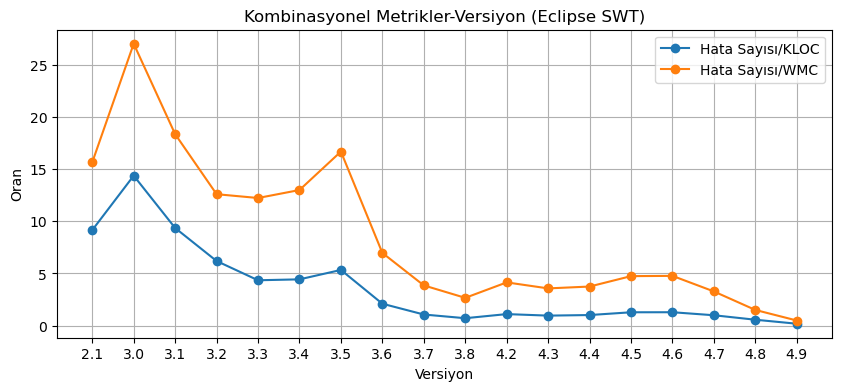

object


In [20]:
# t_mergedMeanBugCountsDf, t_mergedStdBugCountsDf,t_mergedMaxBugCountsDf 

import matplotlib.pyplot as plt

plt.figure(figsize=(10, 4)) 
locVersions['Kloc'] = locVersions['loc']/1000
locVersions['BugDensity'] = locVersions['Bug ID']/locVersions['Kloc']
meanCkGroupedVersions['Version'] = meanCkGroupedVersions['Version'].astype(str)
plt.plot(locVersions['Version'], locVersions['BugDensity'], marker='o', linestyle='-', label='Hata Sayısı/KLOC')
plt.plot(meanCkGroupedVersions['Version'], meanCkGroupedVersions['BugWeight'], marker='o', linestyle='-', label='Hata Sayısı/WMC')


plt.ylabel('Oran')
plt.grid(True)

plt.xlabel('Versiyon')
plt.title('Kombinasyonel Metrikler-Versiyon (Eclipse SWT)')
plt.legend()  
plt.show()

print(meanCkGroupedVersions['Version'].dtype)

In [ ]:
from scipy import stats

veri = t_mergedMeanBugCountsDf['Bug Count'].values

statistik, p_degeri = stats.shapiro(veri)

# Test istatistiği ve p değeri
print(f"Test İstatistiği: {statistik}, P Değeri: {p_degeri}")

# P değerinin anlamlılık seviyesiyle karşılaştırılması
anlamli_seviye = 0.05
if p_degeri > anlamli_seviye:
    print("Örnek veri normal dağılıma uymaktadır.")
else:
    print("Örnek veri normal dağılıma uymamaktadır.")

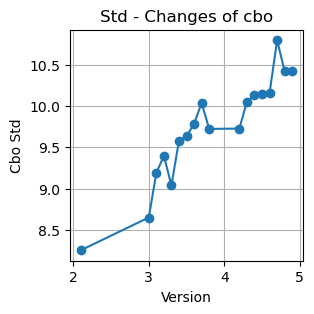

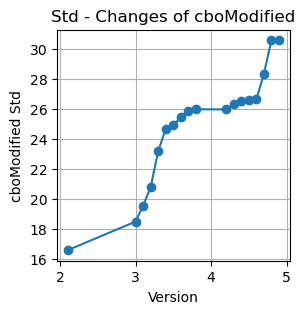

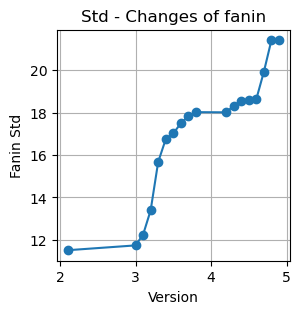

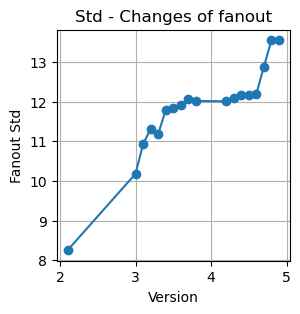

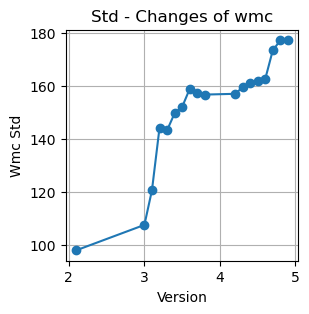

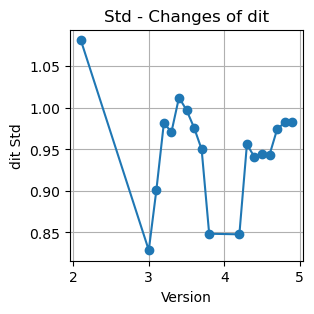

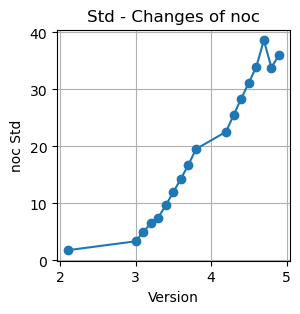

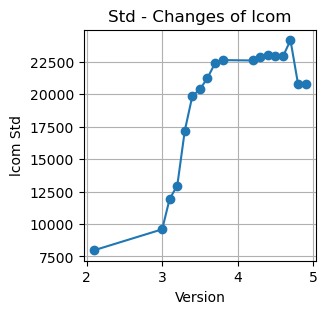

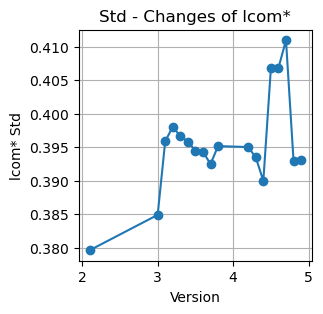

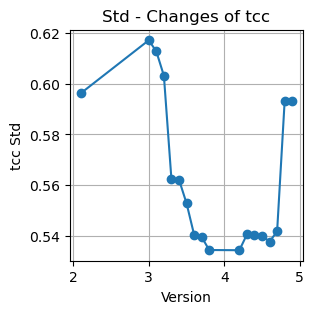

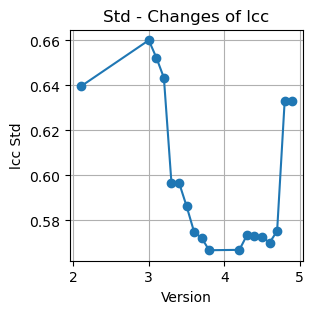

In [15]:
plt.figure(figsize=(3, 3)) 
plt.plot(stdCkGroupedVersions['Version'], stdCkGroupedVersions['cbo'], marker='o', linestyle='-')
plt.xlabel('Version')
plt.ylabel('Cbo Std')
plt.title('Std - Changes of cbo')
plt.grid(True)
plt.show()

plt.figure(figsize=(3, 3)) 
plt.plot(stdCkGroupedVersions['Version'], stdCkGroupedVersions['cboModified'], marker='o', linestyle='-')
plt.xlabel('Version')
plt.ylabel('cboModified Std')
plt.title('Std - Changes of cboModified')
plt.grid(True)
plt.show()

plt.figure(figsize=(3, 3)) 
plt.plot(stdCkGroupedVersions['Version'], stdCkGroupedVersions['fanin'], marker='o', linestyle='-')
plt.xlabel('Version')
plt.ylabel('Fanin Std')
plt.title('Std - Changes of fanin')
plt.grid(True)
plt.show()

plt.figure(figsize=(3, 3)) 
plt.plot(stdCkGroupedVersions['Version'], stdCkGroupedVersions['fanout'], marker='o', linestyle='-')
plt.xlabel('Version')
plt.ylabel('Fanout Std')
plt.title('Std - Changes of fanout')
plt.grid(True)
plt.show()

plt.figure(figsize=(3, 3)) 
plt.plot(stdCkGroupedVersions['Version'], stdCkGroupedVersions['wmc'], marker='o', linestyle='-')
plt.xlabel('Version')
plt.ylabel('Wmc Std')
plt.title('Std - Changes of wmc')
plt.grid(True)
plt.show()

plt.figure(figsize=(3, 3)) 
plt.plot(stdCkGroupedVersions['Version'], stdCkGroupedVersions['dit'], marker='o', linestyle='-')
plt.xlabel('Version')
plt.ylabel('dit Std')
plt.title('Std - Changes of dit')
plt.grid(True)
plt.show()

plt.figure(figsize=(3, 3)) 
plt.plot(stdCkGroupedVersions['Version'], stdCkGroupedVersions['noc'], marker='o', linestyle='-')
plt.xlabel('Version')
plt.ylabel('noc Std')
plt.title('Std - Changes of noc')
plt.grid(True)
plt.show()

plt.figure(figsize=(3, 3)) 
plt.plot(stdCkGroupedVersions['Version'], stdCkGroupedVersions['lcom'], marker='o', linestyle='-')
plt.xlabel('Version')
plt.ylabel('lcom Std')
plt.title('Std - Changes of lcom')
plt.grid(True)
plt.show()

plt.figure(figsize=(3, 3)) 
plt.plot(stdCkGroupedVersions['Version'], stdCkGroupedVersions['lcom*'], marker='o', linestyle='-')
plt.xlabel('Version')
plt.ylabel('lcom* Std')
plt.title('Std - Changes of lcom*')
plt.grid(True)
plt.show()

plt.figure(figsize=(3, 3)) 
plt.plot(stdCkGroupedVersions['Version'], stdCkGroupedVersions['tcc'], marker='o', linestyle='-')
plt.xlabel('Version')
plt.ylabel('tcc Std')
plt.title('Std - Changes of tcc')
plt.grid(True)
plt.show()

plt.figure(figsize=(3, 3)) 
plt.plot(stdCkGroupedVersions['Version'], stdCkGroupedVersions['lcc'], marker='o', linestyle='-')
plt.xlabel('Version')
plt.ylabel('lcc Std')
plt.title('Std - Changes of lcc')
plt.grid(True)
plt.show()

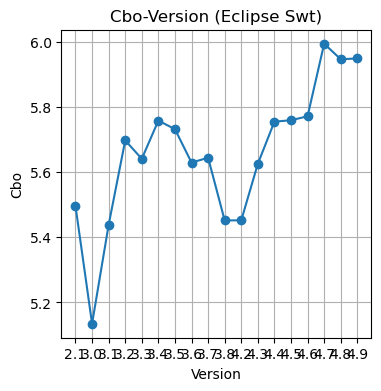

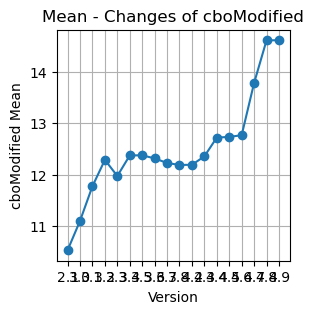

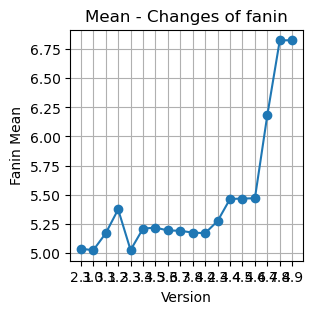

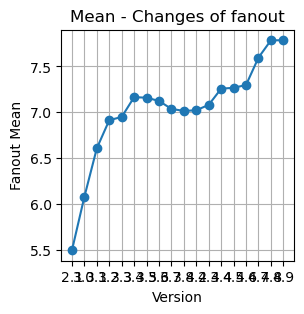

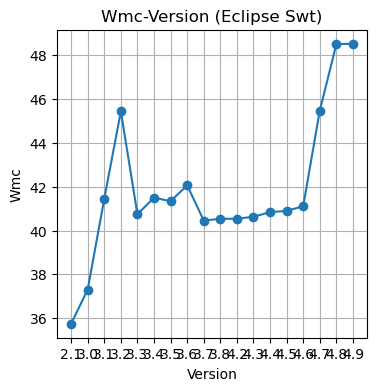

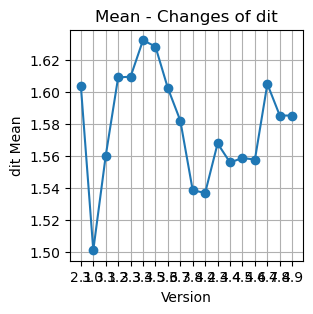

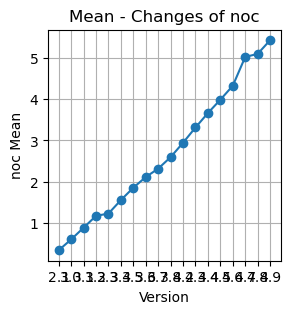

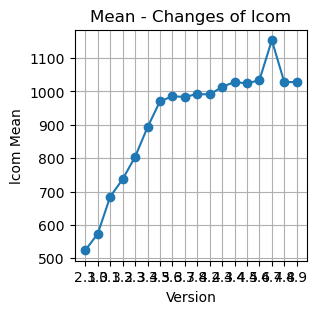

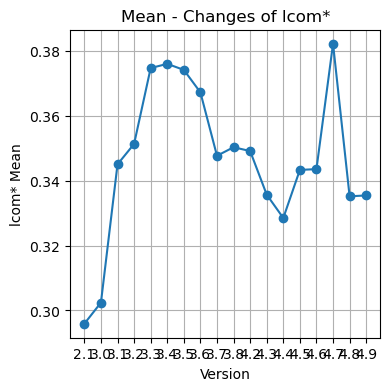

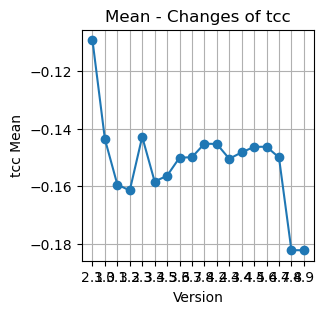

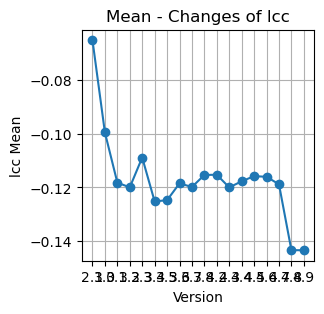

In [16]:
import matplotlib.pyplot as plt

plt.figure(figsize=(4, 4)) 
plt.plot(meanCkGroupedVersions['Version'], meanCkGroupedVersions['cbo'], marker='o', linestyle='-')
plt.xlabel('Version')
plt.ylabel('Cbo')
plt.title('Cbo-Version (Eclipse Swt)')
plt.grid(True)
plt.show()

plt.figure(figsize=(3, 3)) 
plt.plot(meanCkGroupedVersions['Version'], meanCkGroupedVersions['cboModified'], marker='o', linestyle='-')
plt.xlabel('Version')
plt.ylabel('cboModified Mean')
plt.title('Mean - Changes of cboModified')
plt.grid(True)
plt.show()

plt.figure(figsize=(3, 3)) 
plt.plot(meanCkGroupedVersions['Version'], meanCkGroupedVersions['fanin'], marker='o', linestyle='-')
plt.xlabel('Version')
plt.ylabel('Fanin Mean')
plt.title('Mean - Changes of fanin')
plt.grid(True)
plt.show()

plt.figure(figsize=(3, 3)) 
plt.plot(meanCkGroupedVersions['Version'], meanCkGroupedVersions['fanout'], marker='o', linestyle='-')
plt.xlabel('Version')
plt.ylabel('Fanout Mean')
plt.title('Mean - Changes of fanout')
plt.grid(True)
plt.show()

plt.figure(figsize=(4, 4)) 
plt.plot(meanCkGroupedVersions['Version'], meanCkGroupedVersions['wmc'], marker='o', linestyle='-')
plt.xlabel('Version')
plt.ylabel('Wmc')
plt.title('Wmc-Version (Eclipse Swt)')
plt.grid(True)
plt.show()

plt.figure(figsize=(3, 3)) 
plt.plot(meanCkGroupedVersions['Version'], meanCkGroupedVersions['dit'], marker='o', linestyle='-')
plt.xlabel('Version')
plt.ylabel('dit Mean')
plt.title('Mean - Changes of dit')
plt.grid(True)
plt.show()

plt.figure(figsize=(3, 3)) 
plt.plot(meanCkGroupedVersions['Version'], meanCkGroupedVersions['noc'], marker='o', linestyle='-')
plt.xlabel('Version')
plt.ylabel('noc Mean')
plt.title('Mean - Changes of noc')
plt.grid(True)
plt.show()

plt.figure(figsize=(3, 3)) 
plt.plot(meanCkGroupedVersions['Version'], meanCkGroupedVersions['lcom'], marker='o', linestyle='-')
plt.xlabel('Version')
plt.ylabel('lcom Mean')
plt.title('Mean - Changes of lcom')
plt.grid(True)
plt.show()

plt.figure(figsize=(4, 4)) 
plt.plot(meanCkGroupedVersions['Version'], meanCkGroupedVersions['lcom*'], marker='o', linestyle='-')
plt.xlabel('Version')
plt.ylabel('lcom* Mean')
plt.title('Mean - Changes of lcom*')
plt.grid(True)
plt.show()

plt.figure(figsize=(3, 3)) 
plt.plot(meanCkGroupedVersions['Version'], meanCkGroupedVersions['tcc'], marker='o', linestyle='-')
plt.xlabel('Version')
plt.ylabel('tcc Mean')
plt.title('Mean - Changes of tcc')
plt.grid(True)
plt.show()

plt.figure(figsize=(3, 3)) 
plt.plot(meanCkGroupedVersions['Version'], meanCkGroupedVersions['lcc'], marker='o', linestyle='-')
plt.xlabel('Version')
plt.ylabel('lcc Mean')
plt.title('Mean - Changes of lcc')
plt.grid(True)
plt.show()

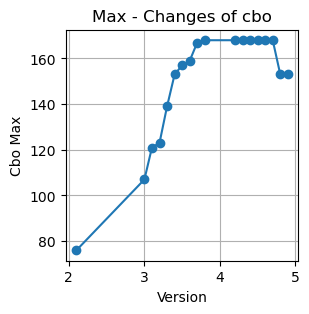

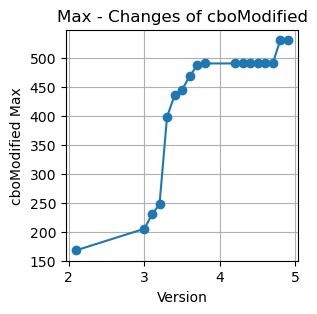

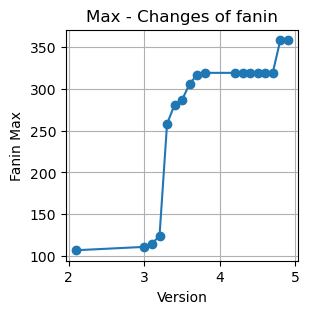

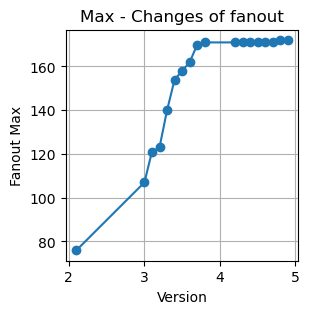

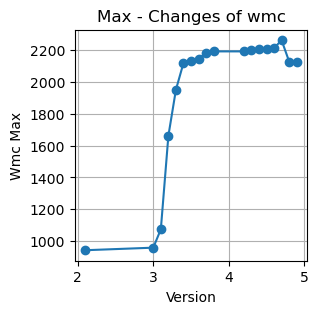

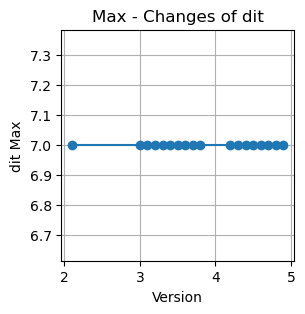

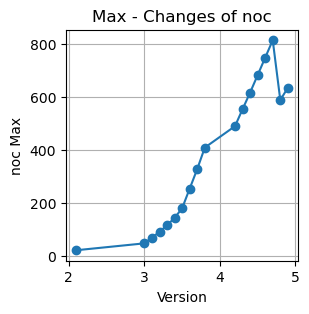

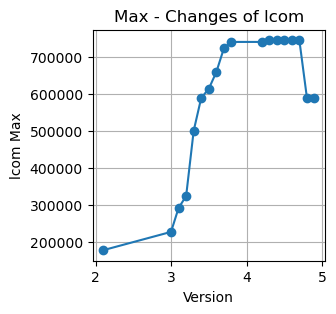

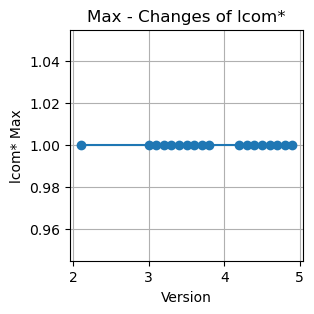

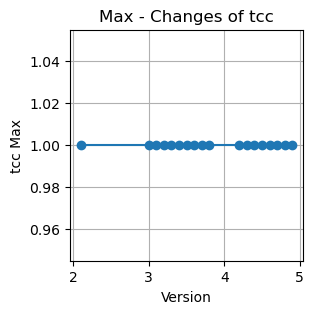

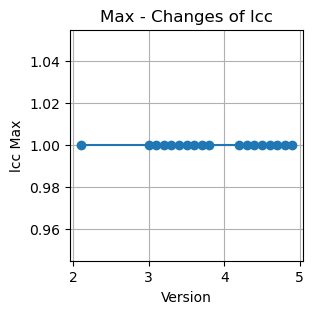

In [17]:
plt.figure(figsize=(3, 3)) 
plt.plot(maxCkGroupedVersions['Version'], maxCkGroupedVersions['cbo'], marker='o', linestyle='-')
plt.xlabel('Version')
plt.ylabel('Cbo Max')
plt.title('Max - Changes of cbo')
plt.grid(True)
plt.show()

plt.figure(figsize=(3, 3)) 
plt.plot(maxCkGroupedVersions['Version'], maxCkGroupedVersions['cboModified'], marker='o', linestyle='-')
plt.xlabel('Version')
plt.ylabel('cboModified Max')
plt.title('Max - Changes of cboModified')
plt.grid(True)
plt.show()

plt.figure(figsize=(3, 3)) 
plt.plot(maxCkGroupedVersions['Version'], maxCkGroupedVersions['fanin'], marker='o', linestyle='-')
plt.xlabel('Version')
plt.ylabel('Fanin Max')
plt.title('Max - Changes of fanin')
plt.grid(True)
plt.show()

plt.figure(figsize=(3, 3)) 
plt.plot(maxCkGroupedVersions['Version'], maxCkGroupedVersions['fanout'], marker='o', linestyle='-')
plt.xlabel('Version')
plt.ylabel('Fanout Max')
plt.title('Max - Changes of fanout')
plt.grid(True)
plt.show()

plt.figure(figsize=(3, 3)) 
plt.plot(maxCkGroupedVersions['Version'], maxCkGroupedVersions['wmc'], marker='o', linestyle='-')
plt.xlabel('Version')
plt.ylabel('Wmc Max')
plt.title('Max - Changes of wmc')
plt.grid(True)
plt.show()

plt.figure(figsize=(3, 3)) 
plt.plot(maxCkGroupedVersions['Version'], maxCkGroupedVersions['dit'], marker='o', linestyle='-')
plt.xlabel('Version')
plt.ylabel('dit Max')
plt.title('Max - Changes of dit')
plt.grid(True)
plt.show()

plt.figure(figsize=(3, 3)) 
plt.plot(maxCkGroupedVersions['Version'], maxCkGroupedVersions['noc'], marker='o', linestyle='-')
plt.xlabel('Version')
plt.ylabel('noc Max')
plt.title('Max - Changes of noc')
plt.grid(True)
plt.show()

plt.figure(figsize=(3, 3)) 
plt.plot(maxCkGroupedVersions['Version'], maxCkGroupedVersions['lcom'], marker='o', linestyle='-')
plt.xlabel('Version')
plt.ylabel('lcom Max')
plt.title('Max - Changes of lcom')
plt.grid(True)
plt.show()

plt.figure(figsize=(3, 3)) 
plt.plot(maxCkGroupedVersions['Version'], maxCkGroupedVersions['lcom*'], marker='o', linestyle='-')
plt.xlabel('Version')
plt.ylabel('lcom* Max')
plt.title('Max - Changes of lcom*')
plt.grid(True)
plt.show()

plt.figure(figsize=(3, 3)) 
plt.plot(maxCkGroupedVersions['Version'], maxCkGroupedVersions['tcc'], marker='o', linestyle='-')
plt.xlabel('Version')
plt.ylabel('tcc Max')
plt.title('Max - Changes of tcc')
plt.grid(True)
plt.show()

plt.figure(figsize=(3, 3)) 
plt.plot(maxCkGroupedVersions['Version'], maxCkGroupedVersions['lcc'], marker='o', linestyle='-')
plt.xlabel('Version')
plt.ylabel('lcc Max')
plt.title('Max - Changes of lcc')
plt.grid(True)
plt.show()